<a href="https://colab.research.google.com/github/Ralmao/wines_clustering/blob/main/wine_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [ ]:
df=pd.read_csv("/content/wine-clustering.csv")

In [ ]:
df

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [ ]:
df.dtypes

Alcohol                 float64
Malic_Acid              float64
Ash                     float64
Ash_Alcanity            float64
Magnesium                 int64
Total_Phenols           float64
Flavanoids              float64
Nonflavanoid_Phenols    float64
Proanthocyanins         float64
Color_Intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [ ]:
df.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

<Axes: >

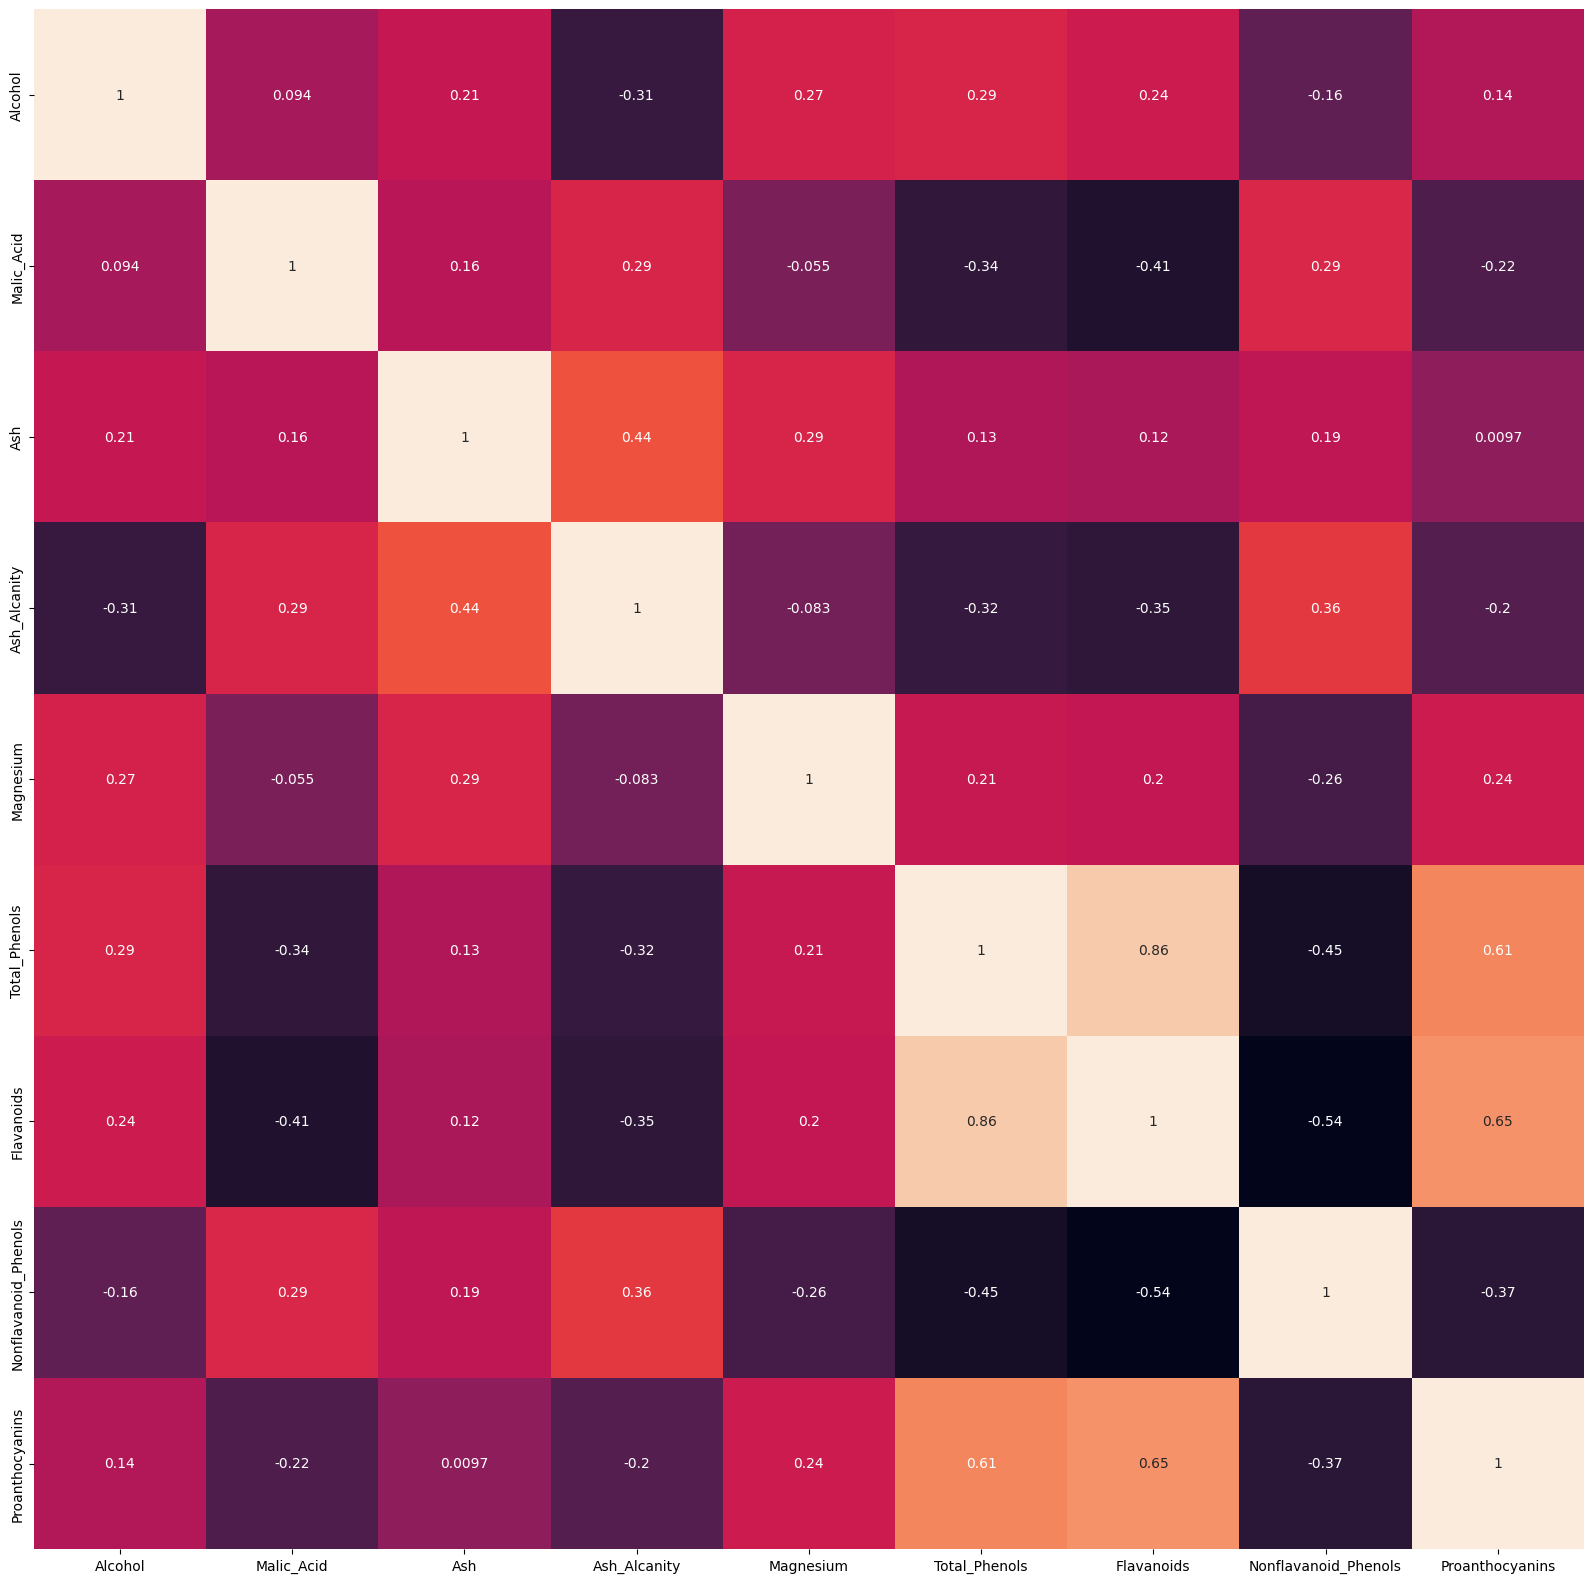

In [ ]:
plt.figure(figsize = (20, 20))
corr_matrix = df.iloc[:, :9].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [ ]:
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(df,
    dimensions = df.columns[:8], color = 'Flavanoids')

fig.update_layout(
    title = 'wine Data',
    width = 1100,
    height = 1100,
)
fig.show()

<Figure size 1500x1500 with 0 Axes>

In [ ]:
scaler = StandardScaler()
wine_df_scaled = scaler.fit_transform(df)

In [ ]:
wine_df_scaled.shape

(178, 13)

In [ ]:

input_df = Input(shape = (13,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(4, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(13, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - utilizado para reducir la dimensión
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(wine_df_scaled, wine_df_scaled, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [ ]:
autoencoder.save_weights('autoencoder_1.h5')

In [ ]:
pred = encoder.predict(wine_df_scaled)

6/6 [==============================] - 0s 3ms/step


In [ ]:
pred

array([[0.00000000e+00, 9.01949406e+00, 1.45557194e+01, 0.00000000e+00],
       [0.00000000e+00, 3.34385681e+00, 7.47237062e+00, 0.00000000e+00],
       [0.00000000e+00, 2.54402423e+00, 9.73810673e+00, 0.00000000e+00],
       [0.00000000e+00, 2.77333546e+00, 1.44072561e+01, 0.00000000e+00],
       [0.00000000e+00, 1.01810694e+00, 4.30226040e+00, 0.00000000e+00],
       [0.00000000e+00, 2.25123072e+00, 1.21562986e+01, 0.00000000e+00],
       [0.00000000e+00, 3.11295009e+00, 9.27887440e+00, 0.00000000e+00],
       [0.00000000e+00, 1.24619162e+00, 7.72980213e+00, 0.00000000e+00],
       [0.00000000e+00, 4.96502066e+00, 1.16984282e+01, 0.00000000e+00],
       [0.00000000e+00, 4.52784777e+00, 9.96342850e+00, 0.00000000e+00],
       [0.00000000e+00, 2.96774030e+00, 1.18910007e+01, 0.00000000e+00],
       [0.00000000e+00, 2.58429432e+00, 7.29930782e+00, 0.00000000e+00],
       [0.00000000e+00, 2.77852154e+00, 8.37971973e+00, 0.00000000e+00],
       [0.00000000e+00, 6.05044365e+00, 1.65504379e

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

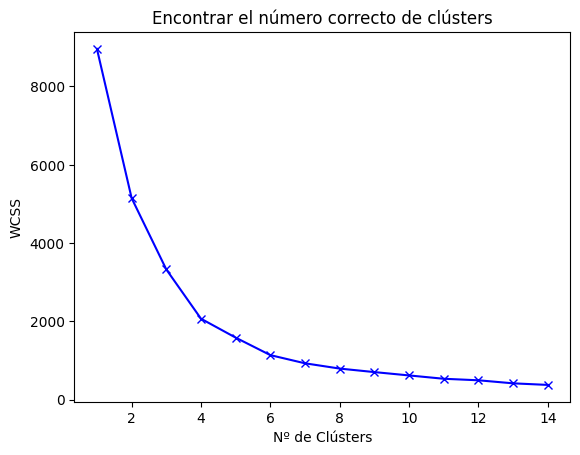

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clústers')
plt.xlabel('Nº de Clústers')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(wine_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
df_cluster_dr = pd.concat([df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,cluster
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,2


In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df.columns])
cluster_centers

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.835232,-0.303810,0.364706,-0.610191,0.577587,0.885237,0.977820,-0.562090,0.580287,0.171063,0.473984,0.779247,1.125185
1,0.164907,0.871547,0.186898,0.524367,-0.075473,-0.979330,-1.215248,0.726064,-0.779706,0.941539,-1.164789,-1.292412,-0.407088
2,-0.926072,-0.394042,-0.494517,0.170602,-0.491712,-0.075983,0.020813,-0.033534,0.058266,-0.901914,0.461804,0.270764,-0.753846


In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [df.columns])
cluster_centers


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806
1,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824
2,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231


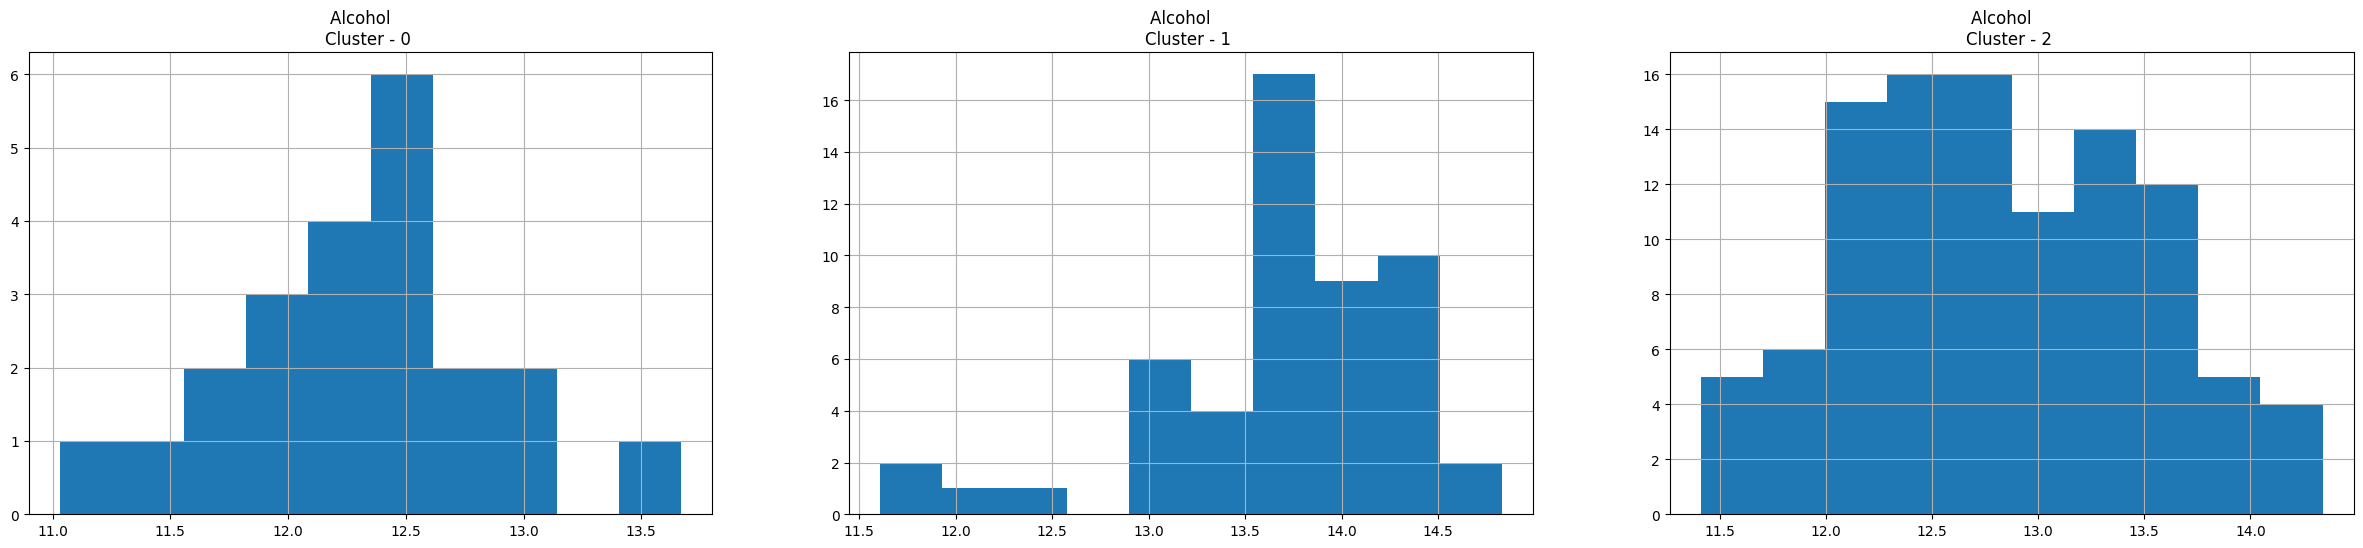

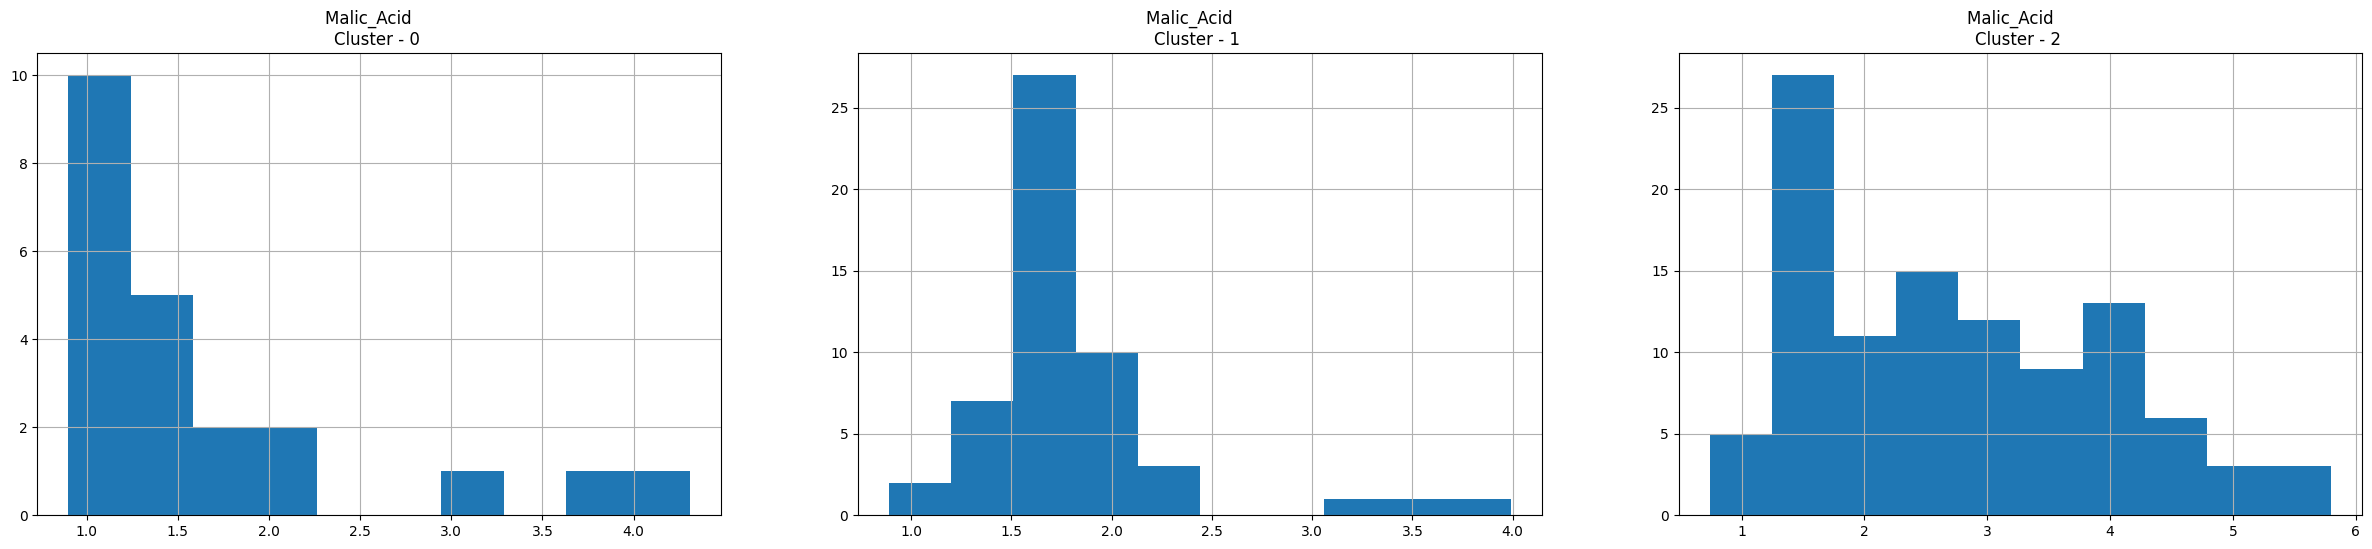

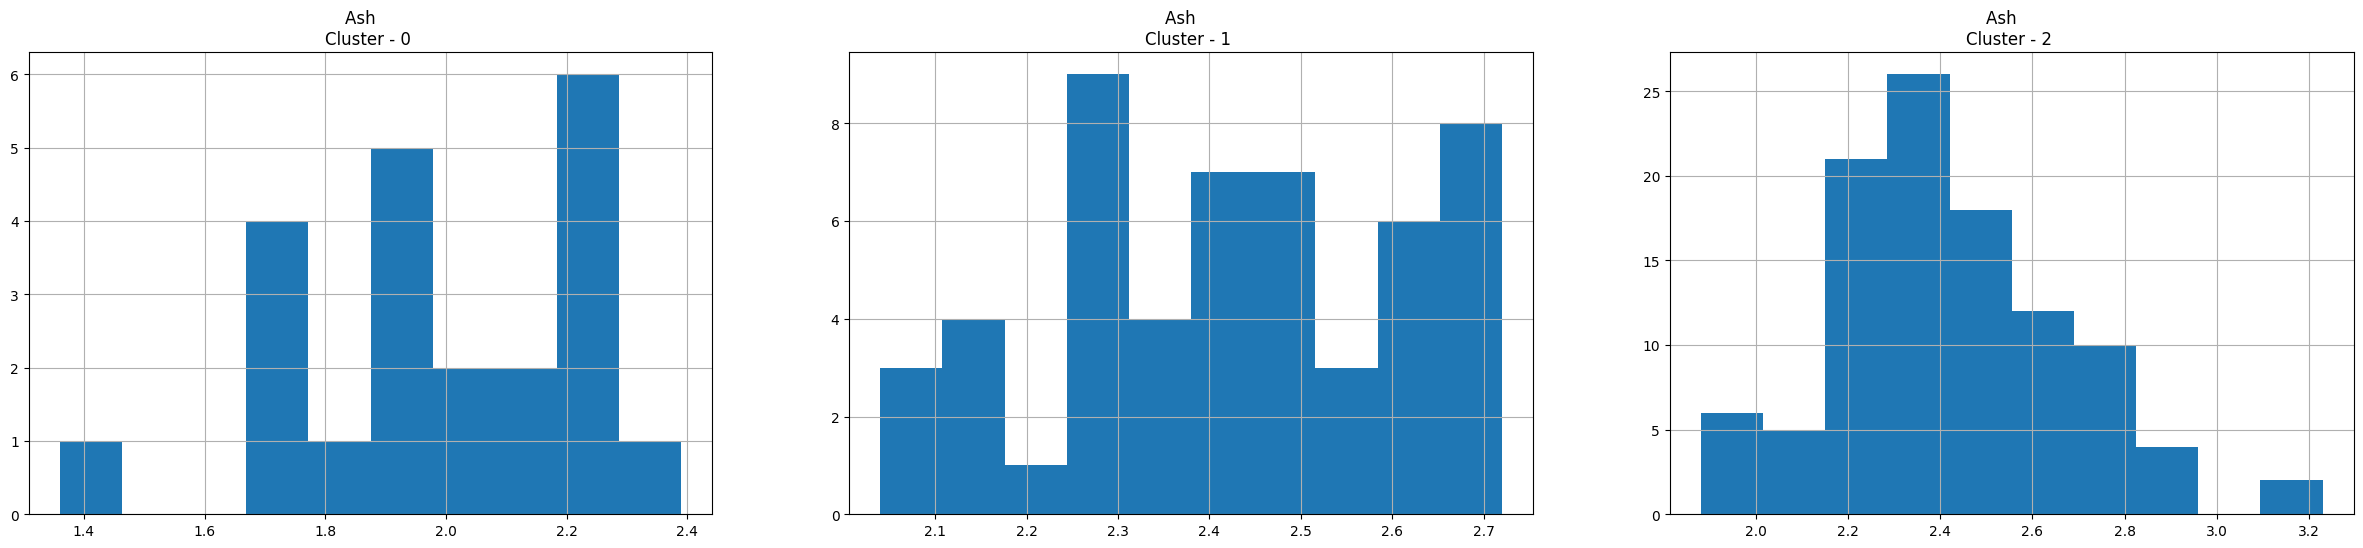

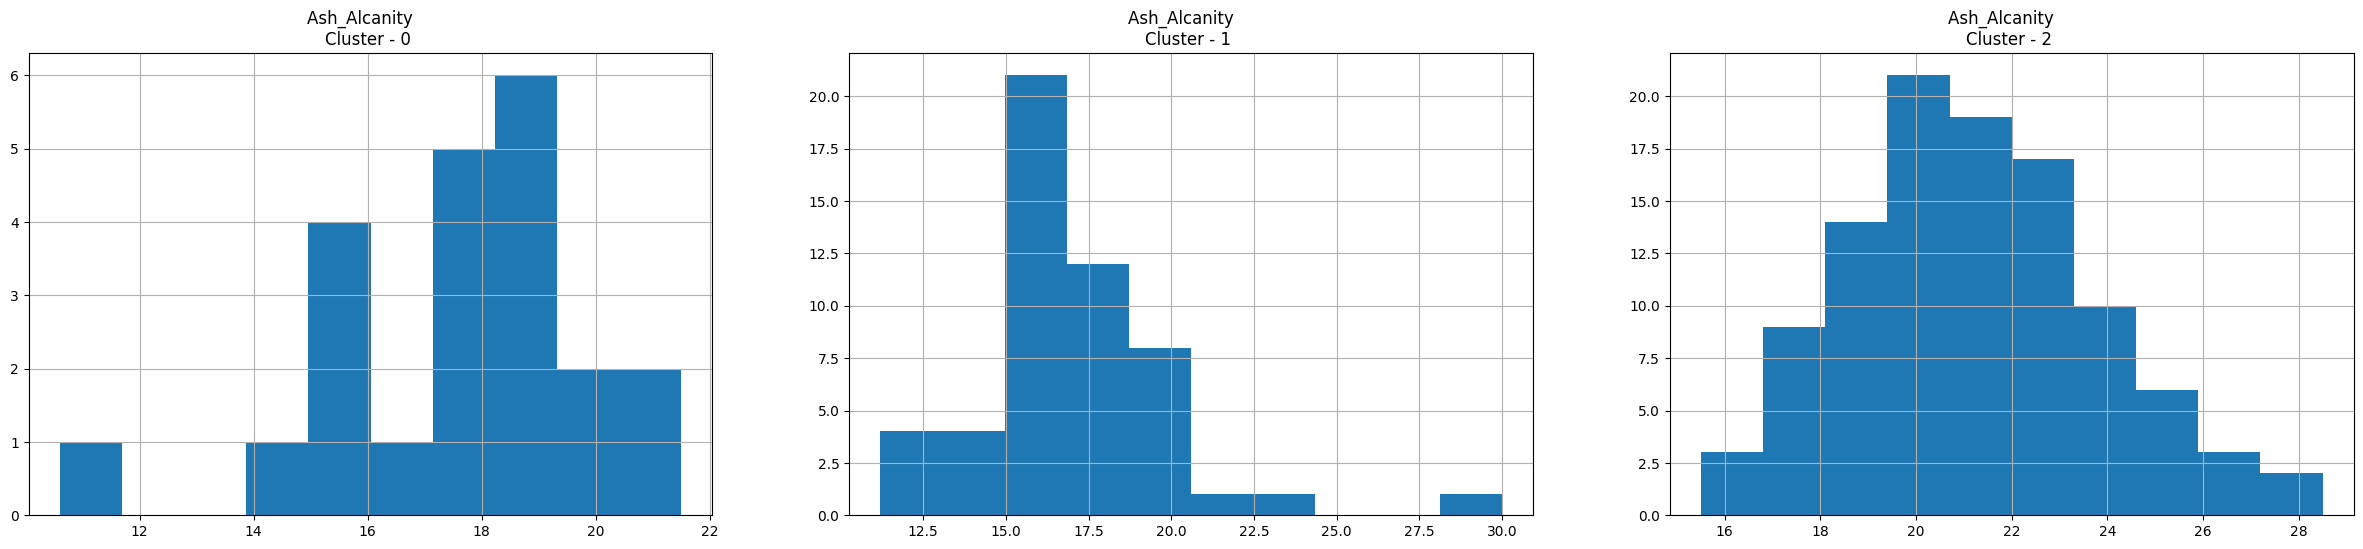

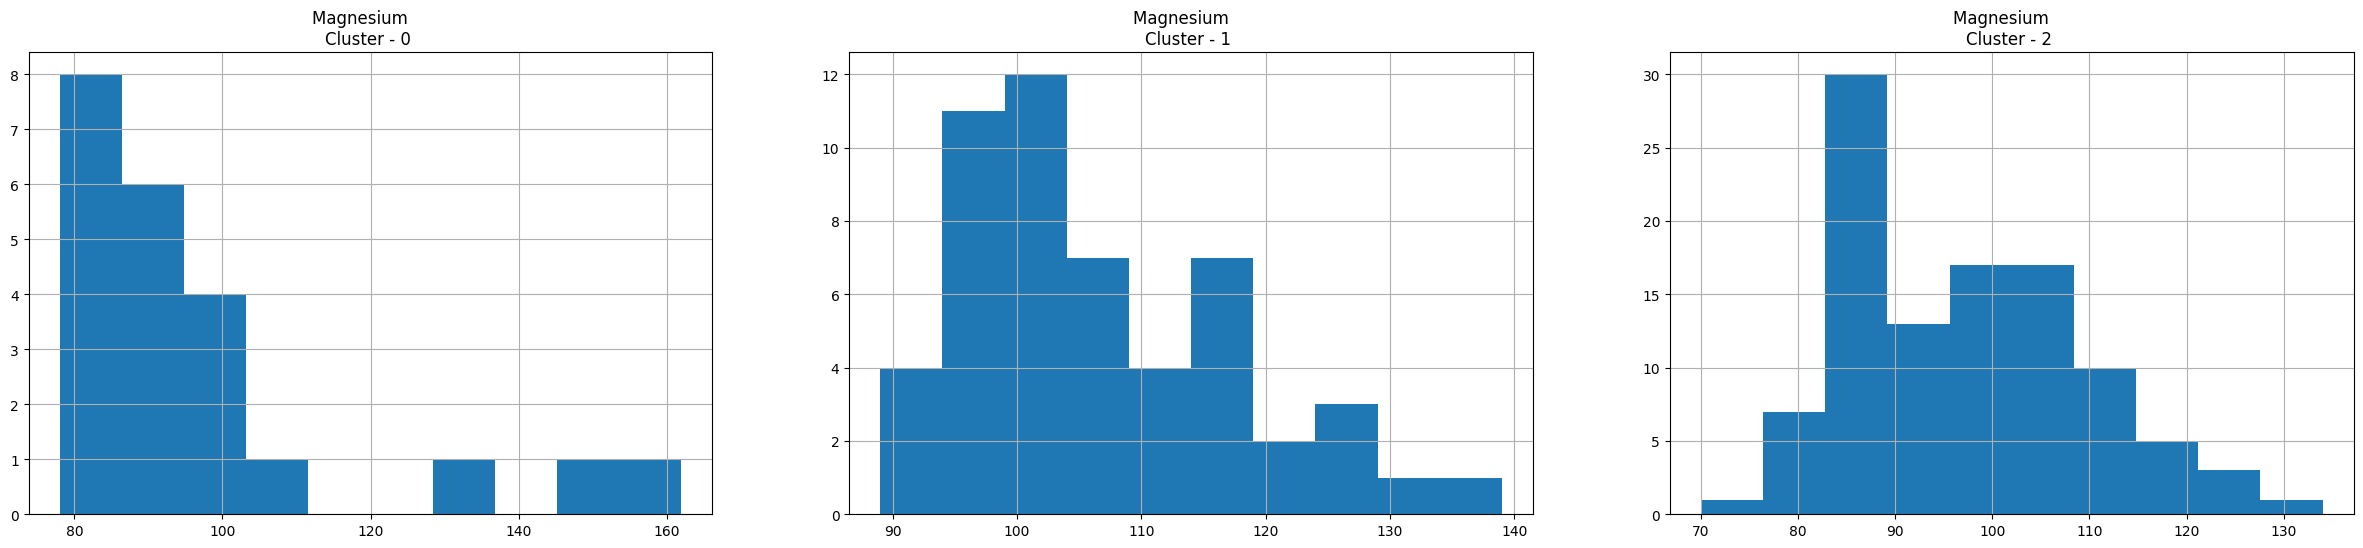

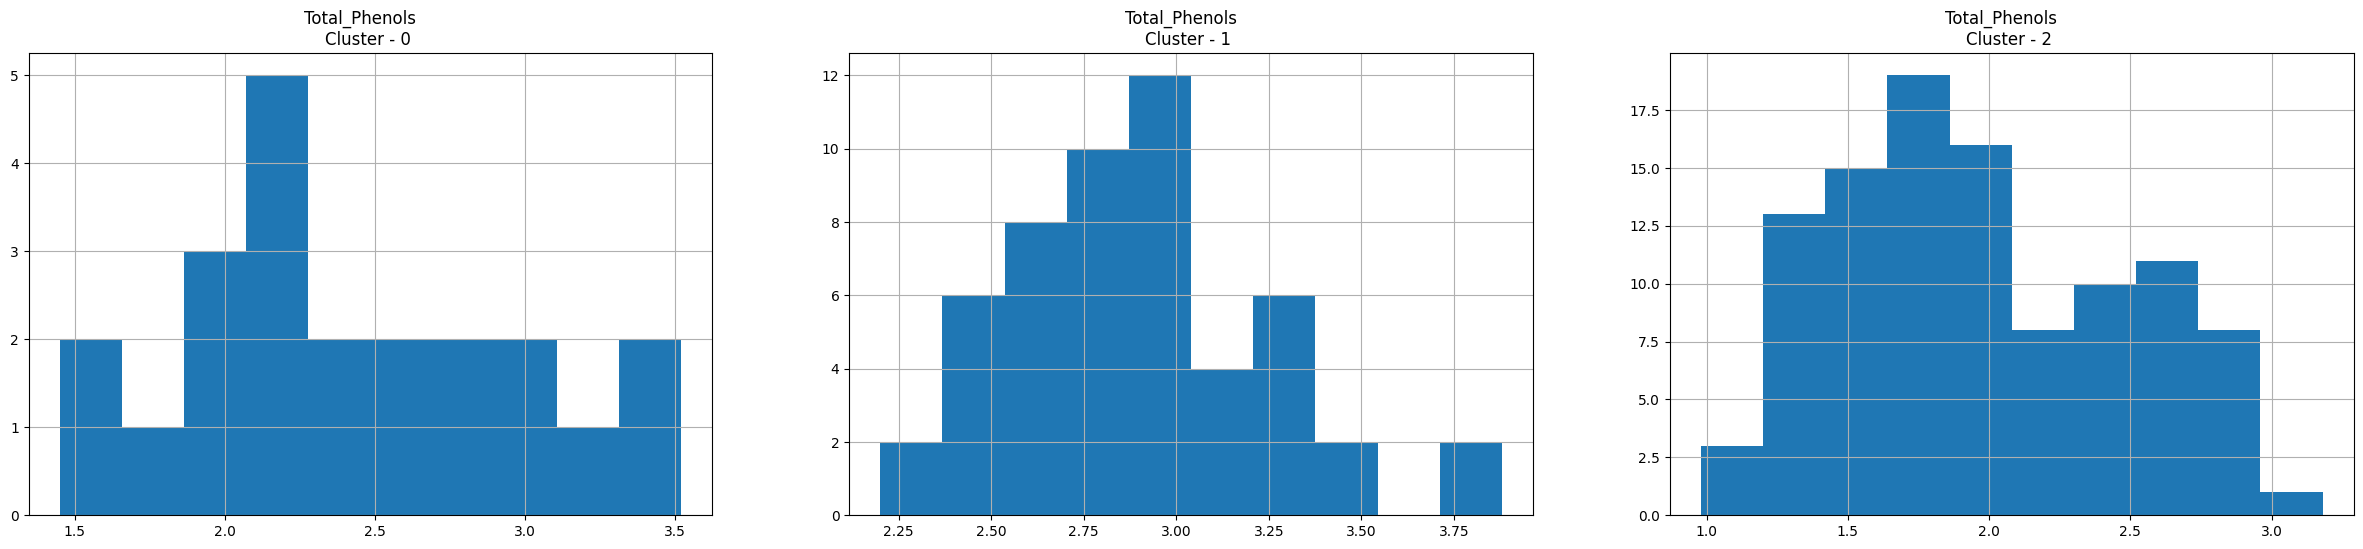

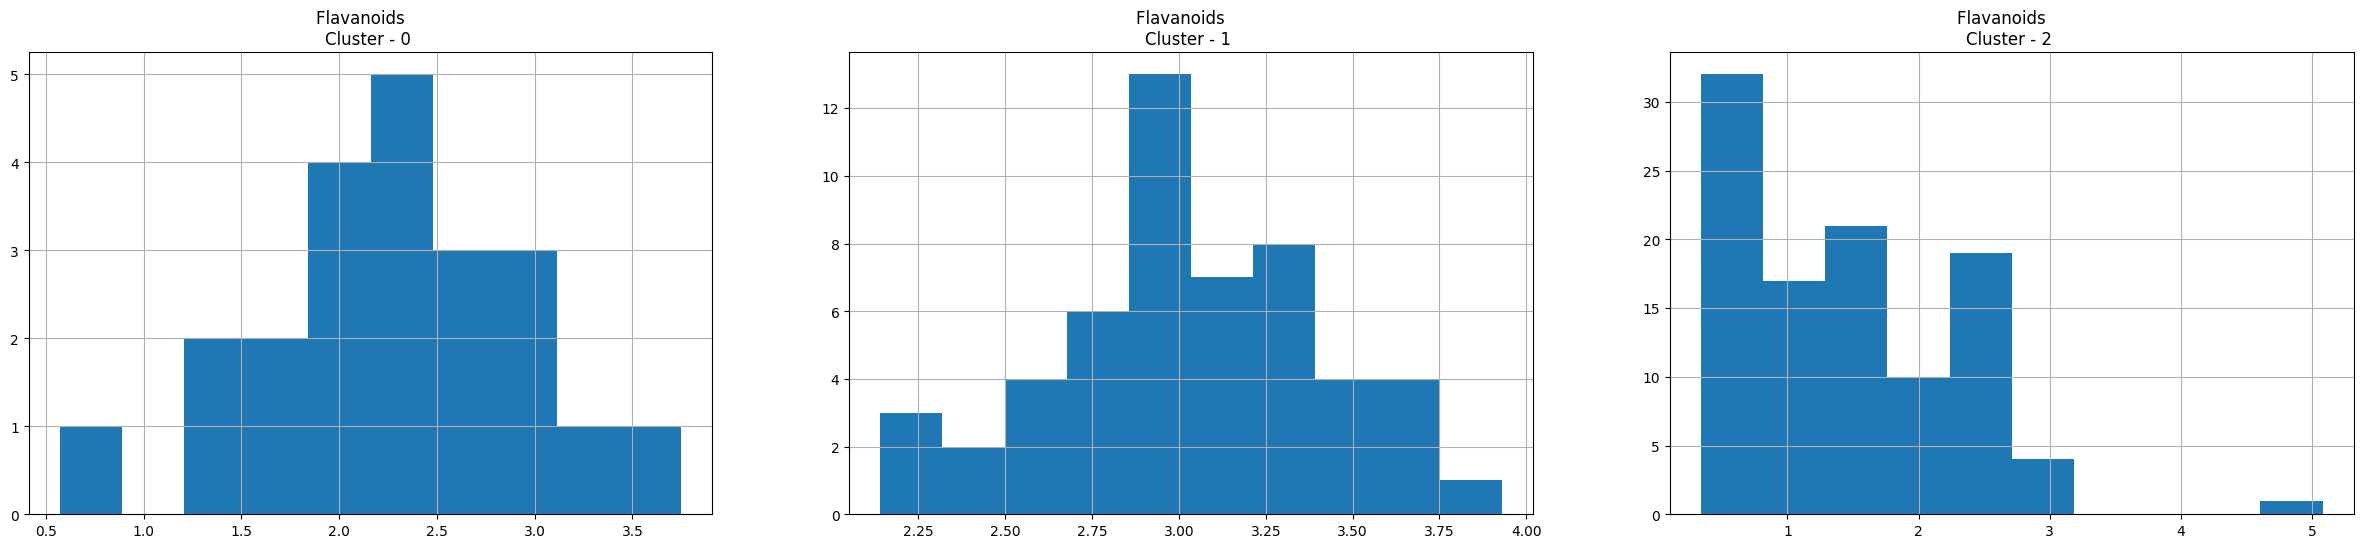

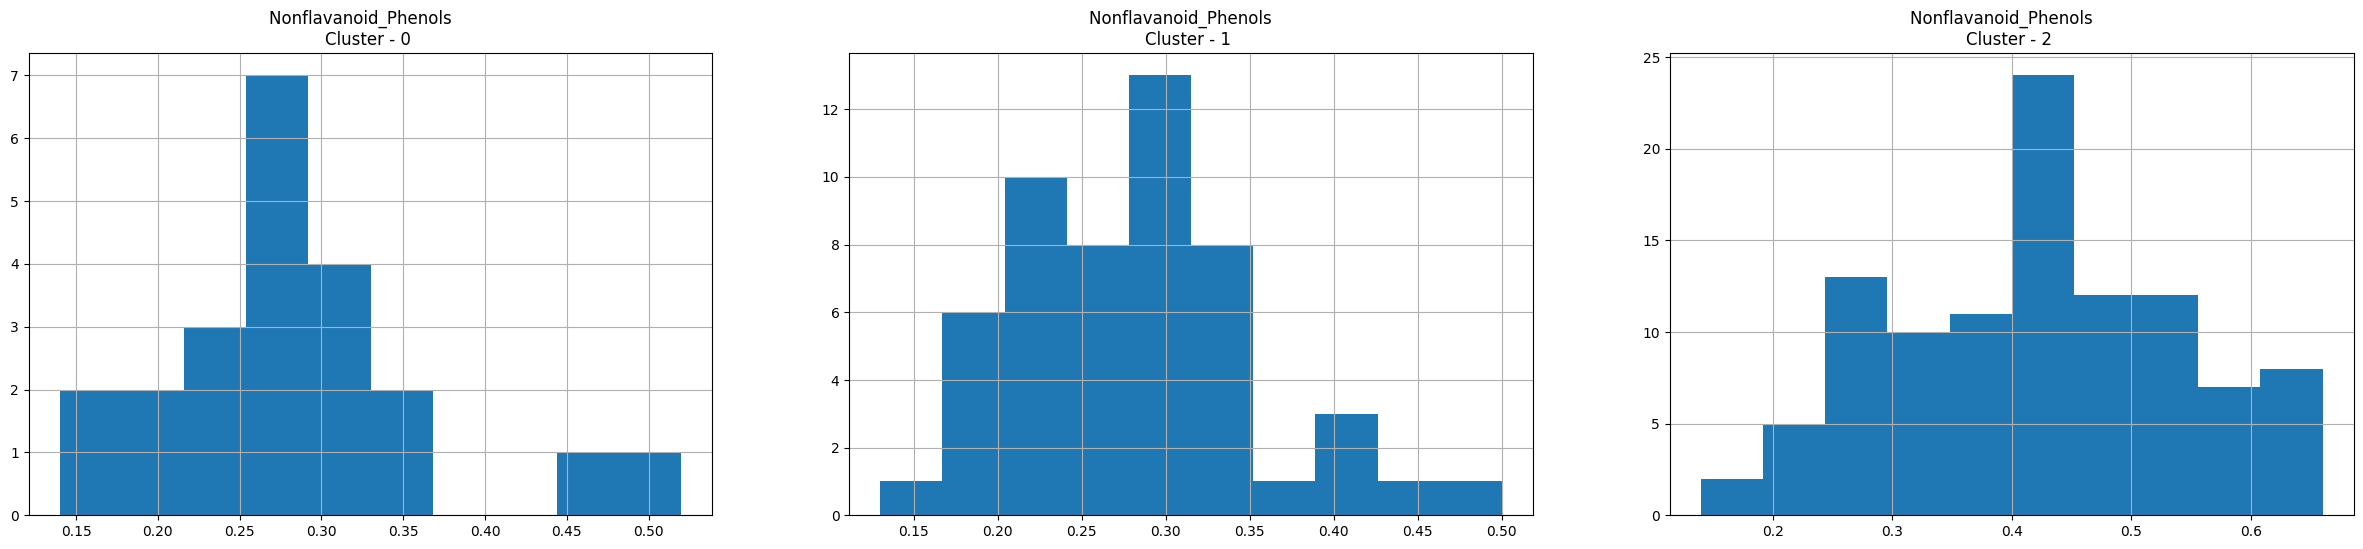

In [ ]:
# plot histogram for each feature based on cluster
for i in df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

In [ ]:
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(wine_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,3.316751,-1.443463,-0.165739
1,2.209465,0.333393,-2.026457
2,2.516740,-1.031151,0.982819
3,3.757066,-2.756372,-0.176192
4,1.008908,-0.869831,2.026688


In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,3.316751,-1.443463,-0.165739,1
1,2.209465,0.333393,-2.026457,1
2,2.516740,-1.031151,0.982819,1
3,3.757066,-2.756372,-0.176192,1
4,1.008908,-0.869831,2.026688,2


In [ ]:
# Visualizar los clústers utilizando 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))